In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import functions.eddy_feedback as ef
import functions.data_wrangling as dw

In [2]:
path = '/home/links/ct715/data_storage/reanalysis/srip_datasets'
ds = xr.open_mfdataset(os.path.join(path, 'JRA55_srip_ubar_div1.nc'))
ds

<xarray.Dataset> Size: 14MB
Dimensions:   (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 6kB 1958-01-14T09:00:00 ... 2016-12-14T09...
  * pressure  (pressure) float32 88B 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 292B -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 5MB dask.array<chunksize=(708, 22, 73), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 5MB dask.array<chunksize=(708, 22, 73), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 5MB dask.array<chunksize=(708, 22, 73), meta=np.ndarray>

In [3]:
print(f"NH: {ef.calculate_efp(ds, data_type='reanalysis', which_div1='div1_pr')}")
print(f"SH: {ef.calculate_efp(ds, data_type='reanalysis', which_div1='div1_pr', calc_south_hemis=True)}")

NH: 0.4502
SH: 0.3584


/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [7]:
def plot_reanalysis_correlation(ds, label='DJF', logscale=True, show_rect=True, latitude='NH',
                                top_atmos=10., cut_poles=False, figsize=(6,6),
                                title_name = '\\nabla_{\\phi} F_{\\phi}', take_seasonal=True,
                                which_div1='div1_pr'):
    """"
    Input: DataArrays of ubar and F_\\phi
            - Dims: (time, level, lat)
                - DATASET MUST BE FULL YEAR FOR SEASONAL MEAN 
            - Subsetted to NH or SH
            - Cut off stratosphere >10. hPa
    
    Output: contourf plot matching Fig.6a in Smith et al., 2022 
    """

    ## SET UP TIME

    # If required, check dimensions and variables are labelled correctly
    correct_dims = all(dim_name in ds.dims for dim_name in ['time', 'level', 'lat'])
    if not correct_dims:
        ds = dw.check_dimensions(ds)

    # choose hemisphere
    if latitude == 'NH':
        ds = ds.where(ds.lat >= 0., drop=True)
        rect_box = (25., 600.)
        season='djf'
    elif latitude == 'SH':
        ds = ds.where(ds.lat <= 0., drop=True)
        rect_box = (-75., 600.)
        season='jas'

    # separate time into annual means
    # and use .load() to force the calculation now
    if take_seasonal:
        ds = ds.sel(time=slice('1979', '2016'))
        ds = dw.seasonal_mean(ds, season=season)


    # set variables
    ubar = ds.ubar
    div1 = ds[which_div1]

    # calculate correlation using built-in Xarray function
    corr = xr.corr(div1, ubar, dim='time')

    # choose top of atmosphere
    corr = corr.where(corr.level >= top_atmos, drop=True)

    if cut_poles:
        corr = corr.where(corr.lat >= -85., drop=True)
        corr = corr.where(corr.lat <= 85., drop=True)

    #------------------------------------------------------------------

    ## PLOTTING TIME

    # # Initiate plot
    # plt.figure(figsize=figsize)

    # # actual plotting
    # plt.contourf(corr.lat.values, corr.level.values, corr, cmap='RdBu_r',
    #              levels=np.linspace(-0.9,0.9,19), extend='both')
    # plt.colorbar(location='bottom', orientation='horizontal', shrink=0.75, label='correlation',
    #          extend='both', ticks=[-0.6,-0.2,0.2,0.6])
    
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(corr.lat.values, corr.level.values, corr, cmap='RdBu_r',
                    levels=np.linspace(-0.9,0.9,19), extend='both')

    # Position for colorbar: [left, bottom, width, height] in figure coordinates (0-1)
    cbar_ax = fig.add_axes([0.15, 0.0005, 0.7, 0.03])  # Adjust as needed
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal', extend='both',
                        ticks=[-0.6, -0.2, 0.2, 0.6])
    cbar.set_label('correlation', fontsize=14)

    # axis alterations
    ax.invert_yaxis()
    ax.set_xlabel('Latitude $(^\\circ N)$', fontsize=14)
    if logscale:
        ax.yscale('log', fontsize=14)
        ax.set_ylabel('Log pressure (hPa)', fontsize=14)
    else:
        ax.set_ylabel('Pressure (hPa)', fontsize=14)
    # plt.title('$Corr(\\bar{{u}}, {0})$ - {1}'.format(title_name, label))
    ax.set_title(f'$Corr(\\bar{{u}}, {title_name})$ - JRA55 (DJF)', fontsize=16)

    # Plot EFP box
    if show_rect:
        rect = patches.Rectangle(rect_box, 50, -400,
                         fill=False, linewidth=2)
        ax.add_patch(rect)
        
    plt.savefig('./plots/poster_correlation_NH_linear.png', bbox_inches='tight', dpi=300)

    plt.show()
  

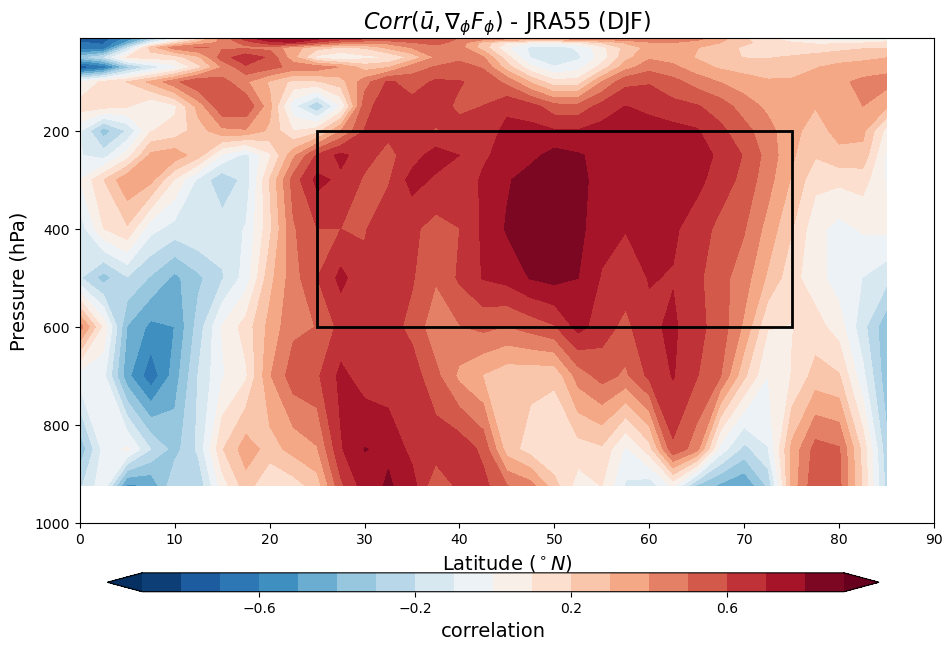

In [9]:
def mm_to_inches(mm):
    return mm / 25.4

# Example usage:
width_mm = 140  # e.g., full-page width in a journal
height_mm = 80

figsize = (mm_to_inches(width_mm*2), mm_to_inches(height_mm*2))

plot_reanalysis_correlation(ds, logscale=False, figsize=figsize)



# Both Hemispheres

In [7]:
ds

<xarray.Dataset> Size: 14MB
Dimensions:   (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time      (time) datetime64[ns] 6kB 1958-01-14T09:00:00 ... 2016-12-14T09...
  * pressure  (pressure) float32 88B 1e+03 925.0 850.0 700.0 ... 5.0 3.0 2.0 1.0
  * latitude  (latitude) float32 292B -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
Data variables:
    ubar      (time, pressure, latitude) float32 5MB dask.array<chunksize=(708, 22, 73), meta=np.ndarray>
    div1_pr   (time, pressure, latitude) float32 5MB dask.array<chunksize=(708, 22, 73), meta=np.ndarray>
    div1_qg   (time, pressure, latitude) float32 5MB dask.array<chunksize=(708, 22, 73), meta=np.ndarray>

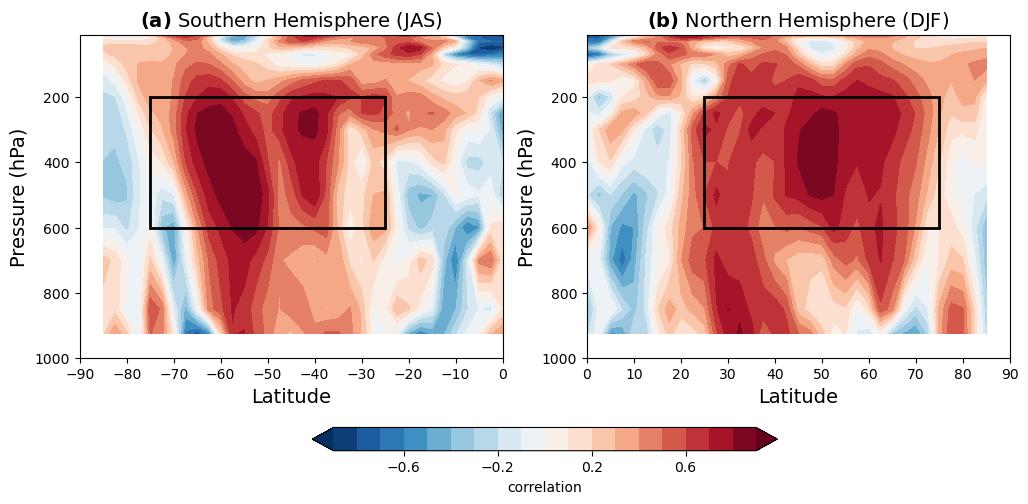

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.10/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import xarray as xr

def plot_reanalysis_correlation_both_hemispheres(ds, label='DJF', logscale=True, show_rect=True,
                                                  top_atmos=10., cut_poles=False, figsize=(12, 6),
                                                  title_name='\\nabla_{\\phi} F_{\\phi}', take_seasonal=True,
                                                  which_div1='div1_pr'):
    """
    Plot correlation between ubar and div1 for both hemispheres side by side.

    Parameters
    ----------
    ds : xarray.Dataset
        Must contain 'ubar' and the specified div1 variable with dims (time, level, lat).
    """

    def process_hemisphere(ds, latitude, season, rect_box):
        hemi_ds = ds.where(ds.latitude >= 0., drop=True) if latitude == 'NH' else ds.where(ds.latitude <= 0., drop=True)
        if take_seasonal:
            hemi_ds = hemi_ds.sel(time=slice('1979', '2016'))
            hemi_ds = dw.seasonal_mean(hemi_ds, season=season)

        ubar = hemi_ds.ubar
        div1 = hemi_ds[which_div1]
        corr = xr.corr(div1, ubar, dim='time')
        corr = corr.where(corr.level >= top_atmos, drop=True)
        if cut_poles:
            corr = corr.where(corr.lat >= -85., drop=True)
            corr = corr.where(corr.lat <= 85., drop=True)
        return corr, rect_box

    # Process each hemisphere
    corr_sh, rect_box_sh = process_hemisphere(ds, 'SH', 'jas', (-75., 600.))
    corr_nh, rect_box_nh = process_hemisphere(ds, 'NH', 'djf', (25., 600.))

    # Plotting
    fig, axes = plt.subplots(ncols=2, figsize=figsize)#, sharey=True)

    for ax, corr, rect_box, hemi_label in zip(
            axes,
            [corr_sh, corr_nh],
            [rect_box_sh, rect_box_nh],
            ['$\\bf{(a)}$ Southern Hemisphere (JAS)', '$\\bf{(b)}$ Northern Hemisphere (DJF)']):

        cf = ax.contourf(corr.lat, corr.level, corr, cmap='RdBu_r',
                         levels=np.linspace(-0.9, 0.9, 19), extend='both')
        ax.invert_yaxis()
        if logscale:
            ax.set_yscale('log')
            ax.set_ylabel('Log pressure (hPa)', fontsize=14)
        else:
            ax.set_ylabel('Pressure (hPa)', fontsize=14)

        ax.set_xlabel('Latitude', fontsize=14)
        ax.set_title(f'{hemi_label}', fontsize=14)

        if show_rect:
            rect = patches.Rectangle(rect_box, 50, -400, fill=False, linewidth=2)
            ax.add_patch(rect)

    # Add a shared colorbar
    cbar = fig.colorbar(cf, ax=axes, location='bottom', orientation='horizontal',
                        shrink=0.5, label='correlation', extend='both',
                        ticks=[-0.6, -0.2, 0.2, 0.6])
    
    # fig.suptitle(f'$Corr(\\bar{{u}}, {title_name})$ - {label}', fontsize=14)
    # plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
plot_reanalysis_correlation_both_hemispheres(ds, logscale=False)